<h1><center>Titanic: efficient ensembling and optimization</center></h1>

<center><img src="https://www.dlt.travel/immagine/33923/magazine-titanic2.jpg"></center>

<a id="top"></a>

<div class="list-group" id="list-tab" role="tablist">
<h3 class="list-group-item list-group-item-action active" data-toggle="list" style='background:Black; border:0' role="tab" aria-controls="home"><center>Quick navigation</center></h3>

* [1. Feature engineering](#1)
* [2. Single models training and optimization](#2)
* [3. SuperLearner training and optimization](#3)
* [4. Final submission](#4)
    
    
## Best LB score is in Version 80.
    
    
#### Keras neural network for Titanic classification problem: <a href="https://www.kaggle.com/isaienkov/keras-neural-network-architecture-optimization">Titanic: Keras Neural Network architecture optimization</a>
    
#### Hyperparameter tunning methods for Titanic classification problem: <a href="https://www.kaggle.com/isaienkov/hyperparameters-tuning-techniques">Titanic: hyperparameters tuning techniques</a>

In [1]:
import numpy as np
import pandas as pd

from mlens.ensemble import SuperLearner

from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import GradientBoostingClassifier, ExtraTreesClassifier, AdaBoostClassifier, RandomForestClassifier, BaggingClassifier
from sklearn.linear_model import RidgeClassifier, Perceptron, PassiveAggressiveClassifier, LogisticRegression, SGDClassifier

import optuna
from optuna.samplers import TPESampler

import matplotlib.pyplot as plt
import plotly.express as px

import warnings
from sklearn.exceptions import ConvergenceWarning

[MLENS] backend: threading


In [2]:
# To see optuna progress you need to comment this row
optuna.logging.set_verbosity(optuna.logging.WARNING)
warnings.filterwarnings(action='ignore', category=ConvergenceWarning)

<a id="1"></a>
<h2 style='background:black; border:0; color:white'><center>1. Feature engineering<center><h2>

#### In this notebook I will not focus on preprocessing and feature engineering steps, just show how to build your efficient ensemble in few lines of code. I use almost the same features as in the most of kernels in current competition.

In [3]:
train = pd.read_csv('/kaggle/input/titanic/train.csv')
test = pd.read_csv('/kaggle/input/titanic/test.csv')

In [4]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


Lets see percent of NaNs for every column in training set

In [5]:
for col in train.columns:
    print(col, str(round(100* train[col].isnull().sum() / len(train), 2)) + '%')

PassengerId 0.0%
Survived 0.0%
Pclass 0.0%
Name 0.0%
Sex 0.0%
Age 19.87%
SibSp 0.0%
Parch 0.0%
Ticket 0.0%
Fare 0.0%
Cabin 77.1%
Embarked 0.22%


Here is some basic preprocessing to get fast training and test datasets.

In [6]:
train['LastName'] = train['Name'].str.split(',', expand=True)[0]
test['LastName'] = test['Name'].str.split(',', expand=True)[0]
ds = pd.concat([train, test])

sur = list()
died = list()

for index, row in ds.iterrows():
    s = ds[(ds['LastName']==row['LastName']) & (ds['Survived']==1)]
    d = ds[(ds['LastName']==row['LastName']) & (ds['Survived']==0)]
    s=len(s)
    if row['Survived'] == 1:
        s-=1
    d=len(d)
    if row['Survived'] == 0:
        d-=1
    sur.append(s)
    died.append(d)
    
ds['FamilySurvived'] = sur
ds['FamilyDied'] = died
ds['FamilySize'] = ds['SibSp'] + ds['Parch'] + 1
ds['IsAlone'] = 0
ds.loc[ds['FamilySize'] == 1, 'IsAlone'] = 1
ds['Fare'] = ds['Fare'].fillna(train['Fare'].median())
ds['Embarked'] = ds['Embarked'].fillna('Q')

train = ds[ds['Survived'].notnull()]
test = ds[ds['Survived'].isnull()]
test = test.drop(['Survived'], axis=1)

train['rich_woman'] = 0
test['rich_woman'] = 0
train['men_3'] = 0
test['men_3'] = 0

train.loc[(train['Pclass']<=2) & (train['Sex']=='female'), 'rich_woman'] = 1
test.loc[(test['Pclass']<=2) & (test['Sex']=='female'), 'rich_woman'] = 1
train.loc[(train['Pclass']==3) & (train['Sex']=='male'), 'men_3'] = 1
test.loc[(test['Pclass']==3) & (test['Sex']=='male'), 'men_3'] = 1

train['rich_woman'] = train['rich_woman'].astype(np.int8)
test['rich_woman'] = test['rich_woman'].astype(np.int8)

train["Cabin"] = pd.Series([i[0] if not pd.isnull(i) else 'X' for i in train['Cabin']])
test['Cabin'] = pd.Series([i[0] if not pd.isnull(i) else 'X' for i in test['Cabin']])

for cat in ['Pclass', 'Sex', 'Embarked', 'Cabin']:
    train = pd.concat([train, pd.get_dummies(train[cat], prefix=cat)], axis=1)
    train = train.drop([cat], axis=1)
    test = pd.concat([test, pd.get_dummies(test[cat], prefix=cat)], axis=1)
    test = test.drop([cat], axis=1)
    
train = train.drop(['PassengerId', 'Ticket', 'LastName', 'SibSp', 'Parch', 'Sex_male', 'Name'], axis=1)
test =  test.drop(['PassengerId', 'Ticket', 'LastName', 'SibSp', 'Parch', 'Sex_male', 'Name'], axis=1)

train = train.fillna(-1)
test = test.fillna(-1)

train.head()

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/opt/conda/lib/python3.7/site-packages/pandas/core/indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/s

,Survived,Age,Fare,FamilySurvived,FamilyDied,FamilySize,IsAlone,rich_woman,men_3,Pclass_1,...,Embarked_S,Cabin_A,Cabin_B,Cabin_C,Cabin_D,Cabin_E,Cabin_F,Cabin_G,Cabin_T,Cabin_X
0,0.0,22.0,7.2500,0,1,2,0,0,1,0,...,1,0,0,0,0,0,0,0,0,1
1,1.0,38.0,71.2833,0,0,2,0,1,0,1,...,0,0,0,1,0,0,0,0,0,0
2,1.0,26.0,7.9250,0,0,1,1,0,0,0,...,1,0,0,0,0,0,0,0,0,1
3,1.0,35.0,53.1000,0,1,2,0,1,0,1,...,1,0,0,1,0,0,0,0,0,0
4,0.0,35.0,8.0500,1,0,1,1,0,1,0,...,1,0,0,0,0,0,0,0,0,1


Let's do some visualization.

In [7]:
fig = px.box(
    train, 
    x="Survived", 
    y="Age", 
    points='all',
    title='Age & Survived box plot',
    width=700,
    height=500
)

fig.show()

We can see from training set that almost all people with Age higher than 63 years didn't survive. Can use these information in modeling post processing.

In [8]:
fig = px.box(
    train, 
    x="Survived", 
    y="Fare", 
    points='all',
    title='Fare & Survived box plot',
    width=700,
    height=500
)

fig.show()

In [9]:
fig = px.box(
    train, 
    x="Survived", 
    y="FamilySize", 
    points='all',
    title='Family Size & Survived box plot',
    width=700,
    height=500
)

fig.show()

Another one thing. People with family size more than 7 didn't survive.

In [10]:
fig = px.box(
    train, 
    x="Survived", 
    y="FamilyDied", 
    points='all',
    title='Family Died & Survived box plot',
    width=700,
    height=500
)

fig.show()

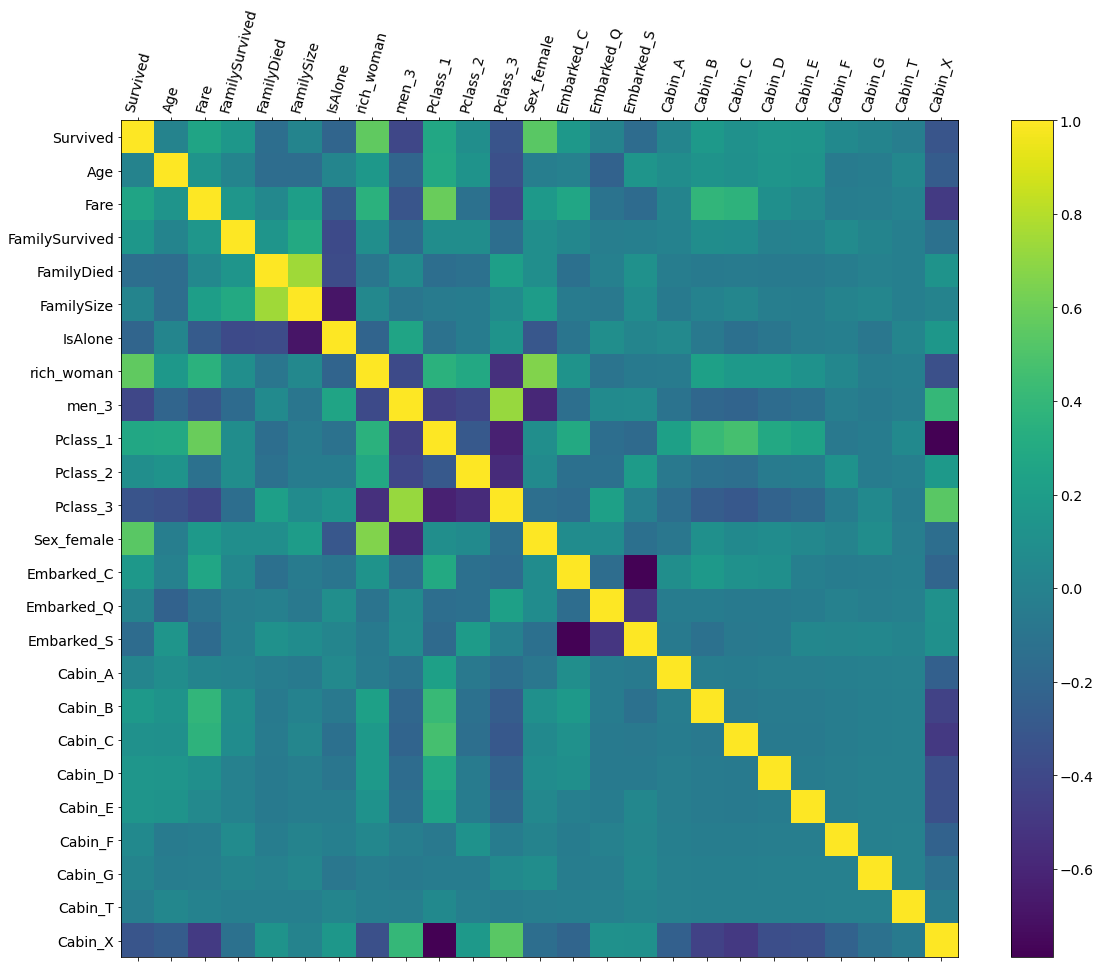

In [11]:
f = plt.figure(
    figsize=(19, 15)
)

plt.matshow(
    train.corr(), 
    fignum=f.number
)

plt.xticks(
    range(train.shape[1]), 
    train.columns, 
    fontsize=14, 
    rotation=75
)

plt.yticks(
    range(train.shape[1]), 
    train.columns, 
    fontsize=14
)

cb = plt.colorbar()
cb.ax.tick_params(
    labelsize=14
)

Lets create train and test dataset and create holdout set for validation.

In [12]:
train.head()

,Survived,Age,Fare,FamilySurvived,FamilyDied,FamilySize,IsAlone,rich_woman,men_3,Pclass_1,...,Embarked_S,Cabin_A,Cabin_B,Cabin_C,Cabin_D,Cabin_E,Cabin_F,Cabin_G,Cabin_T,Cabin_X
0,0.0,22.0,7.2500,0,1,2,0,0,1,0,...,1,0,0,0,0,0,0,0,0,1
1,1.0,38.0,71.2833,0,0,2,0,1,0,1,...,0,0,0,1,0,0,0,0,0,0
2,1.0,26.0,7.9250,0,0,1,1,0,0,0,...,1,0,0,0,0,0,0,0,0,1
3,1.0,35.0,53.1000,0,1,2,0,1,0,1,...,1,0,0,1,0,0,0,0,0,0
4,0.0,35.0,8.0500,1,0,1,1,0,1,0,...,1,0,0,0,0,0,0,0,0,1


In [13]:
y = train['Survived']
X = train.drop(['Survived', 'Cabin_T'], axis=1)
X_test = test.copy()

X, X_val, y, y_val = train_test_split(X, y, random_state=0, test_size=0.2, shuffle=False)

<a id="2"></a>
<h2 style='background:black; border:0; color:white'><center>2. Single models training and optimization<center><h2>

Lets create some separate single models and check accuracy score. We also try to optimize every single model using optuna framework. As we can see we can get some better results with it.

In [14]:
class Optimizer:
    def __init__(self, metric, trials=30):
        self.metric = metric
        self.trials = trials
        self.sampler = TPESampler(seed=666)
        
    def objective(self, trial):
        model = create_model(trial)
        model.fit(X, y)
        preds = model.predict(X_val)
        if self.metric == 'acc':
            return accuracy_score(y_val, preds)
        else:
            return f1_score(y_val, preds)
            
    def optimize(self):
        study = optuna.create_study(direction="maximize", sampler=self.sampler)
        study.optimize(self.objective, n_trials=self.trials)
        return study.best_params

In [15]:
rf = RandomForestClassifier(
    random_state=666
)
rf.fit(X, y)
preds = rf.predict(X_val)

print('Random Forest accuracy: ', accuracy_score(y_val, preds))
print('Random Forest f1-score: ', f1_score(y_val, preds))

def create_model(trial):
    max_depth = trial.suggest_int("max_depth", 2, 6)
    n_estimators = trial.suggest_int("n_estimators", 2, 150)
    min_samples_leaf = trial.suggest_int("min_samples_leaf", 1, 10)
    model = RandomForestClassifier(
        min_samples_leaf=min_samples_leaf, 
        n_estimators=n_estimators, 
        max_depth=max_depth, 
        random_state=666
    )
    return model

optimizer = Optimizer('f1')
rf_f1_params = optimizer.optimize()
rf_f1_params['random_state'] = 666
rf_f1 = RandomForestClassifier(
    **rf_f1_params
)
rf_f1.fit(X, y)
preds = rf_f1.predict(X_val)

print('Optimized on F1 score')
print('Optimized Random Forest: ', accuracy_score(y_val, preds))
print('Optimized Random Forest f1-score: ', f1_score(y_val, preds))

optimizer = Optimizer('acc')
rf_acc_params = optimizer.optimize()
rf_acc_params['random_state'] = 666
rf_acc = RandomForestClassifier(
    **rf_acc_params
)
rf_acc.fit(X, y)
preds = rf_acc.predict(X_val)

print('Optimized on accuracy')
print('Optimized Random Forest: ', accuracy_score(y_val, preds))
print('Optimized Random Forest f1-score: ', f1_score(y_val, preds))

Random Forest accuracy:  0.8491620111731844
Random Forest f1-score:  0.7804878048780488
Optimized on F1 score
Optimized Random Forest:  0.8491620111731844
Optimized Random Forest f1-score:  0.7610619469026548
Optimized on accuracy
Optimized Random Forest:  0.8547486033519553
Optimized Random Forest f1-score:  0.7636363636363634


In [16]:
xgb = XGBClassifier(
    random_state=666
)
xgb.fit(X, y)
preds = xgb.predict(X_val)

print('XGBoost accuracy: ', accuracy_score(y_val, preds))
print('XGBoost f1-score: ', f1_score(y_val, preds))

def create_model(trial):
    max_depth = trial.suggest_int("max_depth", 2, 6)
    n_estimators = trial.suggest_int("n_estimators", 1, 150)
    learning_rate = trial.suggest_uniform('learning_rate', 0.0000001, 1)
    gamma = trial.suggest_uniform('gamma', 0.0000001, 1)
    subsample = trial.suggest_uniform('subsample', 0.0001, 1.0)
    model = XGBClassifier(
        learning_rate=learning_rate, 
        n_estimators=n_estimators, 
        max_depth=max_depth, 
        gamma=gamma, 
        subsample=subsample,
        random_state=666
    )
    return model

optimizer = Optimizer('f1')
xgb_f1_params = optimizer.optimize()
xgb_f1_params['random_state'] = 666
xgb_f1 = XGBClassifier(
    **xgb_f1_params
)
xgb_f1.fit(X, y)
preds = xgb_f1.predict(X_val)

print('Optimized on F1 score')
print('Optimized XGBoost accuracy: ', accuracy_score(y_val, preds))
print('Optimized XGBoost f1-score: ', f1_score(y_val, preds))

optimizer = Optimizer('acc')
xgb_acc_params = optimizer.optimize()
xgb_acc_params['random_state'] = 666
xgb_acc = XGBClassifier(
    **xgb_acc_params
)
xgb_acc.fit(X, y)
preds = xgb_acc.predict(X_val)

print('Optimized on accuracy')
print('Optimized XGBoost accuracy: ', accuracy_score(y_val, preds))
print('Optimized XGBoost f1-score: ', f1_score(y_val, preds))

XGBoost accuracy:  0.8324022346368715
XGBoost f1-score:  0.765625
Optimized on F1 score
Optimized XGBoost accuracy:  0.8603351955307262
Optimized XGBoost f1-score:  0.8062015503875969
Optimized on accuracy
Optimized XGBoost accuracy:  0.8547486033519553
Optimized XGBoost f1-score:  0.7936507936507936


In [17]:
lgb = LGBMClassifier(
    random_state=666
)
lgb.fit(X, y)
preds = lgb.predict(X_val)

print('LightGBM accuracy: ', accuracy_score(y_val, preds))
print('LightGBM f1-score: ', f1_score(y_val, preds))

def create_model(trial):
    max_depth = trial.suggest_int("max_depth", 2, 6)
    n_estimators = trial.suggest_int("n_estimators", 1, 150)
    learning_rate = trial.suggest_uniform('learning_rate', 0.0000001, 1)
    num_leaves = trial.suggest_int("num_leaves", 2, 3000)
    min_child_samples = trial.suggest_int('min_child_samples', 3, 200)
    model = LGBMClassifier(
        learning_rate=learning_rate, 
        n_estimators=n_estimators, 
        max_depth=max_depth, 
        num_leaves=num_leaves, 
        min_child_samples=min_child_samples,
        random_state=666
    )
    return model

optimizer = Optimizer('f1')
lgb_f1_params = optimizer.optimize()
lgb_f1_params['random_state'] = 666
lgb_f1 = LGBMClassifier(
    **lgb_f1_params
)
lgb_f1.fit(X, y)
preds = lgb_f1.predict(X_val)

print('Optimized on F1-score')
print('Optimized LightGBM accuracy: ', accuracy_score(y_val, preds))
print('Optimized LightGBM f1-score: ', f1_score(y_val, preds))

optimizer = Optimizer('acc')
lgb_acc_params = optimizer.optimize()
lgb_acc_params['random_state'] = 666
lgb_acc = LGBMClassifier(
    **lgb_acc_params
)
lgb_acc.fit(X, y)
preds = lgb_acc.predict(X_val)

print('Optimized on accuracy')
print('Optimized LightGBM accuracy: ', accuracy_score(y_val, preds))
print('Optimized LightGBM f1-score: ', f1_score(y_val, preds))

LightGBM accuracy:  0.8659217877094972
LightGBM f1-score:  0.8095238095238094
Optimized on F1-score
Optimized LightGBM accuracy:  0.8770949720670391
Optimized LightGBM f1-score:  0.828125
Optimized on accuracy
Optimized LightGBM accuracy:  0.8770949720670391
Optimized LightGBM f1-score:  0.828125


In [18]:
lr = LogisticRegression(
    random_state=666
)
lr.fit(X, y)
preds = lr.predict(X_val)

print('Logistic Regression: ', accuracy_score(y_val, preds))
print('Logistic Regression f1-score: ', f1_score(y_val, preds))

Logistic Regression:  0.8379888268156425
Logistic Regression f1-score:  0.7642276422764227


In [19]:
dt = DecisionTreeClassifier(
    random_state=666
)
dt.fit(X, y)
preds = dt.predict(X_val)

print('Decision Tree accuracy: ', accuracy_score(y_val, preds))
print('Decision Tree f1-score: ', f1_score(y_val, preds))

def create_model(trial):
    max_depth = trial.suggest_int("max_depth", 2, 6)
    min_samples_split = trial.suggest_int('min_samples_split', 2, 16)
    min_weight_fraction_leaf = trial.suggest_uniform('min_weight_fraction_leaf', 0.0, 0.5)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 10)
    model = DecisionTreeClassifier(
        min_samples_split=min_samples_split, 
        min_weight_fraction_leaf=min_weight_fraction_leaf, 
        max_depth=max_depth, 
        min_samples_leaf=min_samples_leaf, 
        random_state=666
    )
    return model

optimizer = Optimizer('f1')
dt_f1_params = optimizer.optimize()
dt_f1_params['random_state'] = 666
dt_f1 = DecisionTreeClassifier(
    **dt_f1_params
)
dt_f1.fit(X, y)
preds = dt_f1.predict(X_val)

print('Optimized on F1-score')
print('Optimized Decision Tree accuracy: ', accuracy_score(y_val, preds))
print('Optimized Decision Tree f1-score: ', f1_score(y_val, preds))

optimizer = Optimizer('acc')
dt_acc_params = optimizer.optimize()
dt_acc_params['random_state'] = 666
dt_acc = DecisionTreeClassifier(
    **dt_acc_params
)
dt_acc.fit(X, y)
preds = dt_acc.predict(X_val)

print('Optimized on accuracy')
print('Optimized Decision Tree accuracy: ', accuracy_score(y_val, preds))
print('Optimized Decision Tree f1-score: ', f1_score(y_val, preds))

Decision Tree accuracy:  0.8100558659217877
Decision Tree f1-score:  0.7462686567164178
Optimized on F1-score
Optimized Decision Tree accuracy:  0.8603351955307262
Optimized Decision Tree f1-score:  0.7863247863247864
Optimized on accuracy
Optimized Decision Tree accuracy:  0.8603351955307262
Optimized Decision Tree f1-score:  0.7863247863247864


In [20]:
bc = BaggingClassifier(
    random_state=666
)
bc.fit(X, y)
preds = bc.predict(X_val)

print('Bagging Classifier accuracy: ', accuracy_score(y_val, preds))
print('Bagging Classifier f1-score: ', f1_score(y_val, preds))

def create_model(trial):
    n_estimators = trial.suggest_int('n_estimators', 2, 200)
    max_samples = trial.suggest_int('max_samples', 1, 100)
    model = BaggingClassifier(
        n_estimators=n_estimators, 
        max_samples=max_samples, 
        random_state=666
    )
    return model

optimizer = Optimizer('f1')
bc_f1_params = optimizer.optimize()
bc_f1_params['random_state'] = 666
bc_f1 = BaggingClassifier(
    **bc_f1_params
)
bc_f1.fit(X, y)
preds = bc_f1.predict(X_val)

print('Optimized on F1-score')
print('Optimized Bagging Classifier accuracy: ', accuracy_score(y_val, preds))
print('Optimized Bagging Classifier f1-score: ', f1_score(y_val, preds))

optimizer = Optimizer('acc')
bc_acc_params = optimizer.optimize()
bc_acc_params['random_state'] = 666
bc_acc = BaggingClassifier(
    **bc_acc_params
)
bc_acc.fit(X, y)
preds = bc_acc.predict(X_val)

print('Optimized on accuracy')
print('Optimized Bagging Classifier accuracy: ', accuracy_score(y_val, preds))
print('Optimized Bagging Classifier f1-score: ', f1_score(y_val, preds))

Bagging Classifier accuracy:  0.8491620111731844
Bagging Classifier f1-score:  0.784
Optimized on F1-score
Optimized Bagging Classifier accuracy:  0.8659217877094972
Optimized Bagging Classifier f1-score:  0.7966101694915254
Optimized on accuracy
Optimized Bagging Classifier accuracy:  0.8659217877094972
Optimized Bagging Classifier f1-score:  0.7999999999999999


In [21]:
knn = KNeighborsClassifier()
knn.fit(X, y)
preds = knn.predict(X_val)

print('KNN accuracy: ', accuracy_score(y_val, preds))
print('KNN f1-score: ', f1_score(y_val, preds))

sampler = TPESampler(seed=0)
def create_model(trial):
    n_neighbors = trial.suggest_int("n_neighbors", 2, 25)
    model = KNeighborsClassifier(n_neighbors=n_neighbors)
    return model

optimizer = Optimizer('f1')
knn_f1_params = optimizer.optimize()
knn_f1 = KNeighborsClassifier(
    **knn_f1_params
)
knn_f1.fit(X, y)
preds = knn_f1.predict(X_val)

print('Optimized on F1-score')
print('Optimized KNN accuracy: ', accuracy_score(y_val, preds))
print('Optimized KNN f1-score: ', f1_score(y_val, preds))

optimizer = Optimizer('acc')
knn_acc_params = optimizer.optimize()
knn_acc = KNeighborsClassifier(
    **knn_acc_params
)
knn_acc.fit(X, y)
preds = knn_acc.predict(X_val)

print('Optimized on accuracy')
print('Optimized KNN accuracy: ', accuracy_score(y_val, preds))
print('Optimized KNN f1-score: ', f1_score(y_val, preds))

KNN accuracy:  0.7374301675977654
KNN f1-score:  0.6299212598425197
Optimized on F1-score
Optimized KNN accuracy:  0.7653631284916201
Optimized KNN f1-score:  0.671875
Optimized on accuracy
Optimized KNN accuracy:  0.770949720670391
Optimized KNN f1-score:  0.6306306306306305


In [22]:
abc = AdaBoostClassifier(
    random_state=666
)
abc.fit(X, y)
preds = abc.predict(X_val)

print('AdaBoost accuracy: ', accuracy_score(y_val, preds))
print('AdaBoost f1-score: ', f1_score(y_val, preds))

def create_model(trial):
    n_estimators = trial.suggest_int("n_estimators", 2, 150)
    learning_rate = trial.suggest_uniform('learning_rate', 0.0005, 1.0)
    model = AdaBoostClassifier(
        n_estimators=n_estimators, 
        learning_rate=learning_rate, 
        random_state=666
    )
    return model

optimizer = Optimizer('f1')
abc_f1_params = optimizer.optimize()
abc_f1_params['random_state'] = 666
abc_f1 = AdaBoostClassifier(
    **abc_f1_params
)
abc_f1.fit(X, y)
preds = abc_f1.predict(X_val)

print('Optimized on F1-score')
print('Optimized AdaBoost accuracy: ', accuracy_score(y_val, preds))
print('Optimized AdaBoost f1-score: ', f1_score(y_val, preds))

optimizer = Optimizer('acc')
abc_acc_params = optimizer.optimize()
abc_acc_params['random_state'] = 666
abc_acc = AdaBoostClassifier(
    **abc_acc_params
)
abc_acc.fit(X, y)
preds = abc_acc.predict(X_val)

print('Optimized on accuracy')
print('Optimized AdaBoost accuracy: ', accuracy_score(y_val, preds))
print('Optimized AdaBoost f1-score: ', f1_score(y_val, preds))

AdaBoost accuracy:  0.8268156424581006
AdaBoost f1-score:  0.7519999999999999
Optimized on F1-score
Optimized AdaBoost accuracy:  0.8491620111731844
Optimized AdaBoost f1-score:  0.784
Optimized on accuracy
Optimized AdaBoost accuracy:  0.8603351955307262
Optimized AdaBoost f1-score:  0.8031496062992126


In [23]:
et = ExtraTreesClassifier(
    random_state=666
)
et.fit(X, y)
preds = et.predict(X_val)

print('ExtraTreesClassifier accuracy: ', accuracy_score(y_val, preds))
print('ExtraTreesClassifier f1-score: ', f1_score(y_val, preds))

def create_model(trial):
    n_estimators = trial.suggest_int("n_estimators", 2, 150)
    max_depth = trial.suggest_int("max_depth", 2, 6)
    model = ExtraTreesClassifier(
        n_estimators=n_estimators, 
        max_depth=max_depth, 
        random_state=0
    )
    return model

optimizer = Optimizer('f1')
et_f1_params = optimizer.optimize()
et_f1_params['random_state'] = 666
et_f1 = ExtraTreesClassifier(
    **et_f1_params
)
et_f1.fit(X, y)
preds = et_f1.predict(X_val)

print('Optimized on F1-score')
print('Optimized ExtraTreesClassifier accuracy: ', accuracy_score(y_val, preds))
print('Optimized ExtraTreesClassifier f1-score: ', f1_score(y_val, preds))

optimizer = Optimizer('acc')
et_acc_params = optimizer.optimize()
et_acc_params['random_state'] = 666
et_acc = ExtraTreesClassifier(
    **et_acc_params
)
et_acc.fit(X, y)
preds = et_acc.predict(X_val)

print('Optimized on accuracy')
print('Optimized ExtraTreesClassifier accuracy: ', accuracy_score(y_val, preds))
print('Optimized ExtraTreesClassifier f1-score: ', f1_score(y_val, preds))

ExtraTreesClassifier accuracy:  0.8100558659217877
ExtraTreesClassifier f1-score:  0.7301587301587302
Optimized on F1-score
Optimized ExtraTreesClassifier accuracy:  0.8324022346368715
Optimized ExtraTreesClassifier f1-score:  0.7058823529411765
Optimized on accuracy
Optimized ExtraTreesClassifier accuracy:  0.8491620111731844
Optimized ExtraTreesClassifier f1-score:  0.7476635514018692


<a id="3"></a>
<h2 style='background:black; border:0; color:white'><center>3. SuperLearner training and optimization<center><h2>

Now we will create ensemble model named SuperLearner from mlens package. For details check https://machinelearningmastery.com/super-learner-ensemble-in-python/

We are going to use our single models in the first layer and LogisticRegressor as metalearner.

In [24]:
model = SuperLearner(
    folds=5, 
    random_state=666
)

model.add(
    [
        bc, 
        lgb, 
        xgb, 
        rf, 
        dt, 
        knn
    ]
)

model.add_meta(
    LogisticRegression()
)

model.fit(X, y)

preds = model.predict(X_val)

print('SuperLearner accuracy: ', accuracy_score(y_val, preds))
print('SuperLearner f1-score: ', f1_score(y_val, preds))

SuperLearner accuracy:  0.8547486033519553
SuperLearner f1-score:  0.7936507936507936


Let's optimize SuperLearner

In [25]:
mdict = {
    'RF': RandomForestClassifier(random_state=666),
    'XGB': XGBClassifier(random_state=666),
    'LGBM': LGBMClassifier(random_state=666),
    'DT': DecisionTreeClassifier(random_state=666),
    'KNN': KNeighborsClassifier(),
    'BC': BaggingClassifier(random_state=666),
    'OARF': RandomForestClassifier(**rf_acc_params),
    'OFRF': RandomForestClassifier(**rf_f1_params),
    'OAXGB': XGBClassifier(**xgb_acc_params),
    'OFXGB': XGBClassifier(**xgb_f1_params),
    'OALGBM': LGBMClassifier(**lgb_acc_params),
    'OFLGBM': LGBMClassifier(**lgb_f1_params),
    'OADT': DecisionTreeClassifier(**dt_acc_params),
    'OFDT': DecisionTreeClassifier(**dt_f1_params),
    'OAKNN': KNeighborsClassifier(**knn_acc_params),
    'OFKNN': KNeighborsClassifier(**knn_f1_params),
    'OABC': BaggingClassifier(**bc_acc_params),
    'OFBC': BaggingClassifier(**bc_f1_params),
    'OAABC': AdaBoostClassifier(**abc_acc_params),
    'OFABC': AdaBoostClassifier(**abc_f1_params),
    'OAET': ExtraTreesClassifier(**et_acc_params),
    'OFET': ExtraTreesClassifier(**et_f1_params),
    'LR': LogisticRegression(random_state=666),
    'ABC': AdaBoostClassifier(random_state=666),
    'SGD': SGDClassifier(random_state=666), 
    'ET': ExtraTreesClassifier(random_state=666),
    'MLP': MLPClassifier(random_state=666),
    'GB': GradientBoostingClassifier(random_state=666),
    'RDG': RidgeClassifier(random_state=666),
    'PCP': Perceptron(random_state=666),
    'PAC': PassiveAggressiveClassifier(random_state=666)
}

In [26]:
def create_model(trial):
    model_names = list()
    models_list = [
        'RF', 'XGB', 'LGBM', 'DT', 
        'KNN', 'BC', 'OARF', 'OFRF', 
        'OAXGB', 'OFXGB', 'OALGBM', 
        'OFLGBM', 'OADT', 'OFDT', 
        'OAKNN', 'OFKNN', 'OABC', 
        'OFBC', 'OAABC', 'OFABC', 
        'OAET', 'OFET', 'LR', 
        'ABC', 'SGD', 'ET', 
        'MLP', 'GB', 'RDG', 
        'PCP', 'PAC'
    ]
    
    head_list = [
        'RF', 
        'XGB', 
        'LGBM', 
        'DT', 
        'KNN', 
        'BC', 
        'LR', 
        'ABC', 
        'SGD', 
        'ET', 
        'MLP', 
        'GB', 
        'RDG', 
        'PCP', 
        'PAC'
    ]
    
    n_models = trial.suggest_int("n_models", 2, 6)
    for i in range(n_models):
        model_item = trial.suggest_categorical('model_{}'.format(i), models_list)
        if model_item not in model_names:
            model_names.append(model_item)
    
    folds = trial.suggest_int("folds", 2, 6)
    
    model = SuperLearner(
        folds=folds, 
        random_state=666
    )
    
    models = [
        mdict[item] for item in model_names
    ]
    model.add(models)
    head = trial.suggest_categorical('head', head_list)
    model.add_meta(
        mdict[head]
    )
        
    return model

def objective(trial):
    model = create_model(trial)
    model.fit(X, y)
    preds = model.predict(X_val)
    score = accuracy_score(y_val, preds)
    return score

study = optuna.create_study(
    direction="maximize", 
    sampler=sampler
)

study.optimize(
    objective, 
    n_trials=50
)

In [27]:
params = study.best_params

head = params['head']
folds = params['folds']
del params['head'], params['n_models'], params['folds']
result = list()
for key, value in params.items():
    if value not in result:
        result.append(value)
        
result

['OFXGB', 'OADT', 'OFET', 'LGBM', 'OAABC']

In [28]:
model = SuperLearner(
    folds=folds, 
    random_state=666
)

models = [
    mdict[item] for item in result
]
model.add(models)
model.add_meta(mdict[head])

model.fit(X, y)

preds = model.predict(X_val)

print('Optimized SuperLearner accuracy: ', accuracy_score(y_val, preds))
print('Optimized SuperLearner f1-score: ', f1_score(y_val, preds))

Optimized SuperLearner accuracy:  0.888268156424581
Optimized SuperLearner f1-score:  0.8387096774193549


As we can see we improved our best single score only in a few lines of code. Feel free to add new features and try different models inside superlearner.

<a id="4"></a>
<h2 style='background:black; border:0; color:white'><center>4. Final submission<center><h2>

In [29]:
preds = model.predict(X_test)
preds = preds.astype(np.int16)

In [30]:
submission = pd.read_csv('../input/titanic/gender_submission.csv')
submission['Survived'] = preds
submission.to_csv('submission.csv', index=False)

In [31]:
submission.head()

,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,0
4,896,1
